# TorchVision Instance Segmentation Finetuning 

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the Solar Cycle 23 Egression Power Maps Dataset). It contains 175 images with instances of sunquakes, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
import torch
torch.cuda.is_available()

/home/vanessa-m/anaconda3/envs/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# # %%shell

# !pip install cython
# # Install pycocotools, the version by default in Colab
# # has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new kfigeypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset 

Let's write a dataset.

First, let's extract the data

In [3]:
# !unzip './C23_pos.zip'

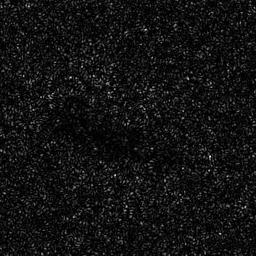

In [4]:
from PIL import Image
file_name = '/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2011_02_15_01_44_00_94.jpg'
im = Image.open(file_name)
im

In [5]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import datetime as dt
import pandas as pd

# CYCLE='23'

# def get_box_coords(rect):
#     coords = rect.get_patch_transform().transform(rect.get_path().vertices[:-1])
#     return (coords[0][0], coords[0][1], coords[2][0], coords[2][1])

# def get_box(cx, cy, w, h):
#     return patches.Rectangle((cx - w/2, cy - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')


# box_df = pd.read_csv("data_c23.csv")
# im_event = file_name.split('/',)[-1][8:27]
# im_time = dt.datetime.strptime(im_event, "%Y_%m_%d_%H_%M_%S")
# im_event = dt.datetime.strftime(im_time, "%d.%m.%Y %H:%M")

# img_box = box_df[box_df['Time'] == im_event].iloc[0]

# fig, ax = plt.subplots()
# ax.imshow(im)

# r = get_box(img_box.b1_cx, img_box.b1_cy, img_box.b1_w, img_box.b1_h)

# ax.add_patch(r)
# plt.show()

So each image has a corresponding segmentation box. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [6]:
import os
import numpy as np
import torch
import torch.utils.data
import random
import pandas as pd
from PIL import Image

class SegDataset(torch.utils.data.Dataset):
    def read_data_set(self, mode='train', cycle='23'):
        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_dir).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = 0 if class_name == "neg" else 1
            if label == 0:
              continue

            img_dir = os.path.join(self.data_dir, class_name)
            img_files = os.walk(img_dir).__next__()[2]
            img_files = sorted(img_files)

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                all_img_files.append(img_file)
                all_labels.append(label)

            
        df = pd.DataFrame(data={'name': all_img_files, 'label' : all_labels})#, 'event': events})

        ## TODO local
        df[['useless1', 'useless2', 'part_of_quake','Year','month','day','Hour','Minute','Seconds','frame']] = df['name'].str.split('_', expand=True)
        # df[['useless1','useless2', 'part_of_quake','Year','month','day','Hour','Minute','Seconds','frame']] = df['name'].str.split('_', expand=True)
    
        df['frame'] = df['frame'].str.extract('(\d+)', expand=False)
        df['frame']=df['frame'].astype(int)

        df['date'] = pd.to_datetime(df[['Year', 'month', 'day', 'Hour','Minute','Seconds']])
        df['event_id'] = df.groupby([df.date, df.part_of_quake]).ngroup()
        df = df.sort_values(by=['date','frame'])
            
        grouping = df.groupby(by=['event_id'])

        groups = [grouping.get_group(x) for x in grouping.groups]
        random.Random(1265).shuffle(groups)

        box_df = pd.read_csv(f"data_c{cycle}.csv")

        data = []
        test_thresh=10
        cnt=0
        for _, group in enumerate(groups):
          for i in range(0,len(group)):
            row = group.iloc[i]
            box_time = dt.datetime.strftime(row['date'],'%d.%m.%Y %H:%M',)

            boxes = []
            box_for_frame = box_df[box_df['Time'] == box_time]
            if (len(box_for_frame) > 0):
                box_for_frame = box_for_frame.iloc[0]
                if (box_for_frame['FS'] <= row['frame'] and box_for_frame['FE'] >= row['frame']):
                    for k in range(1,box_for_frame['box_cnt']+1):
                        box = box_for_frame[[f"b{k}_x0",f"b{k}_y0",f"b{k}_x1",f"b{k}_y1"]]
                        # boxes = np.append(np.array(box), boxes, axis=0) #only add boxes for positives
                        boxes.append(box)
  
            boxes = np.array(boxes)

            if (mode=='train' and cnt <= test_thresh) or (mode=='test' and cnt > test_thresh):
              if (len(boxes) > 0):
               data.append((row['name'], row['label'], boxes))
          cnt+=1

        random.Random(1265).shuffle(data)
        imsh, labsh, boxesh = zip(*data)
        self.imgs, self.labels, self.boxes = list(imsh), list(labsh), list(boxesh)

    def __init__(self, root, mode='train', transforms=None, cycle='23'):
        self.data_dir = root
        self.transforms = transforms
        self.cycle = cycle

        self.read_data_set(mode, cycle)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        # print(img_path)
        img = Image.open(img_path).convert("RGB")

        if (len(self.boxes[idx]) > 0):
          boxes = np.vstack(self.boxes[idx]).astype(float)
        else:
          boxes = torch.empty([0,4])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class (quake object)
        labels = torch.ones((2,), dtype=torch.int64)

        image_id = torch.tensor([idx])

        if (len(self.boxes[idx])!= 0):
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([0])
            
        # suppose all instances are not quake; can't rename this as it's used in the utils
        iscrowd = torch.zeros((2,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        # target["isquake"] = isquake
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [7]:
dataset_ = SegDataset('/home/vanessa-m/Dev/Datasets/C23_pos/', mode='test')

In [8]:
e = dataset_[2]
e

(<PIL.Image.Image image mode=RGB size=256x256>,
 {'boxes': tensor([[109.5000, 153.5000, 121.0000, 167.5000]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([2]),
  'area': tensor([161.]),
  'iscrowd': tensor([0, 0])})

In [9]:
img, t = dataset_[0]

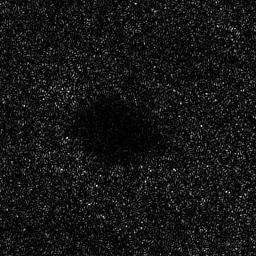

In [10]:
img

In [11]:
b = e[1]['boxes']

In [12]:
b.shape[1] == 0

False

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels`.

## Defining your model



In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (quake) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for Solar Cycle 23 Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # # now get the number of input features for the mask classifier
    # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # hidden_layer = 256
    # # and replace the mask predictor with a new one
    # model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
    #                                                    hidden_layer,
    #                                                    num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

### Helpers

In [14]:
# # %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.8.2


In [15]:
# !cp ./vision/references/detection/utils.py ./
# !cp ./vision/references/detection/transforms.py ./
# !cp ./vision/references/detection/coco_eval.py ./
# !cp ./vision/references/detection/engine.py ./
# !cp ./vision/references/detection/coco_utils.py ./



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [16]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    tr = []
    # converts the image, a PIL image, into a PyTorch Tensor
    tr.append(T.PILToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        tr.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(tr)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [17]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = SegDataset('./C23_pos', 'train', get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn
# )
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions



#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together



Now let's instantiate the model and the optimizer

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and sunquake
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=3e-4,
                            momentum=0.8, weight_decay=0.0001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/vanessa-m/anaconda3/envs/py/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/vanessa-m/anaconda3/envs/py/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We now have the dataset class, the models and the data transforms. Let's instantiate them

In [19]:
# use our dataset and defined transformations
dataset = SegDataset('/home/vanessa-m/Dev/Datasets/C23_pos', 'train', get_transform(train=True))
dataset_test = SegDataset('/home/vanessa-m/Dev/Datasets/C24_pos', 'test', get_transform(train=False), cycle='24')

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [20]:
len(dataset), len(dataset_test), len(data_loader), len(data_loader_test)

(115, 381, 15, 381)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
evaluate(model, data_loader, device=device)

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
evaluate(model, data_loader_test, device=device)

# Load

In [22]:
# torch.save(model.state_dict(), 'object_detector.pt')

model_2 = get_instance_segmentation_model(num_classes)
model_2.to(device)
# model2 = torch.nn.DataParallel(model_2)

/home/vanessa-m/anaconda3/envs/py/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/vanessa-m/anaconda3/envs/py/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
state_dict = torch.load('object_detector.pt', map_location=torch.device('cpu'))

In [74]:
# for key in list(state_dict.keys()):
#     state_dict[key.replace('blocks.0.0.weight', 'blocks.0.weight').replace('blocks.1.0.weight', 'blocks.1.weight').replace('blocks.2.0.weight', 'blocks.2.weight').replace('blocks.3.0.weight', 'blocks.3.weight').replace('blocks.0.0.bias', 'blocks.0.bias').replace('blocks.1.0.bias', 'blocks.1.bias').replace('blocks.2.0.bias', 'blocks.2.bias').replace('blocks.3.0.bias', 'blocks.3.bias').replace('conv.0.0.weight','conv.weight').replace('conv.0.0.bias','conv.bias')] = state_dict.pop(key)

In [24]:
model_2.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
evaluate(model_2, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/381]  eta: 0:01:47  model_time: 0.0289 (0.0289)  evaluator_time: 0.0008 (0.0008)  time: 0.2825  data: 0.2521  max mem: 683
Test:  [100/381]  eta: 0:00:07  model_time: 0.0231 (0.0235)  evaluator_time: 0.0008 (0.0008)  time: 0.0258  data: 0.0012  max mem: 683
Test:  [200/381]  eta: 0:00:04  model_time: 0.0230 (0.0234)  evaluator_time: 0.0007 (0.0008)  time: 0.0256  data: 0.0013  max mem: 683
Test:  [300/381]  eta: 0:00:02  model_time: 0.0230 (0.0234)  evaluator_time: 0.0008 (0.0008)  time: 0.0257  data: 0.0013  max mem: 683
Test:  [380/381]  eta: 0:00:00  model_time: 0.0229 (0.0234)  evaluator_time: 0.0007 (0.0008)  time: 0.0255  data: 0.0013  max mem: 683
Test: Total time: 0:00:10 (0.0264 s / it)
Averaged stats: model_time: 0.0229 (0.0234)  evaluator_time: 0.0007 (0.0008)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) 

# Utils

In [16]:
import os
from torchvision import transforms
import cv2

source_events = ['2011_12_30_event']#, '2012_05_08_event'] #  '2011_12_30_event'
transforms = transforms.Compose([transforms.ToTensor()])
show_all_boxes = [True, False]

In [17]:
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [18]:
files = listdir_fullpath('/home/vanessa-m/Dev/Datasets/C24_pos/neg/') + listdir_fullpath('/home/vanessa-m/Dev/Datasets/C24_pos/poz/')

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [27]:
def get_rect(x0, y0, x1, y1, color=''):
    if x0 > x1:
      aux = x0
      x0 = x1
      x1 = aux
    if y0 > y1:
      aux = y0
      y0 = y1
      y1 = aux
    # print(x0,y0,x1,y1,(x1+x0)/2, (y1+y0)/2, x1-x0, y1-y0)
    if color == '':
      # r = patches.Rectangle(((x1 + x0)/2, (y1 + y0)/2), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')
      r = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')
    else:
      r = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor=color, facecolor='none')
      # r = patches.Rectangle((x0, y0), x1-x0+3, y1-y0+3, linewidth=2, edgecolor=color, facecolor='none')
      # r = patches.Rectangle(((x1 + x0)/2, (y1 + y0)/2), x1-x0, y1-y0, linewidth=2, edgecolor=color, facecolor='none')
    return r

In [ ]:
all = False # for _, all in enumerate(show_all_boxes):
imagepaths = files
images = [cv2.imread(f'{path}') for i, path in enumerate(imagepaths)]
for i in range(500,len(images)):
    tensor_img = transforms(images[i])
    
    if (i%100 == 0):
      print(f'{i}/{len(images)}')
      
    model_2.eval()
    with torch.no_grad(): 
      prediction_test = model_2([tensor_img.to(device)])
      # print(prediction_test)
      # print(imagepaths[i])
      if prediction_test[0]['boxes'].any():
        fig, ax = plt.subplots(figsize=(8,8))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.imshow(images[i])

        if all:
          for k in range(len(prediction_test[0]['boxes'])):
            if prediction_test[0]['scores'][k] > 0.15:
              box = prediction_test[0]['boxes'][k].cpu().numpy() 
              r = get_rect(box[0], box[1], box[2], box[3],color='b' if k > 0 else 'r')
              ax.add_patch(r)
        else:
          box = prediction_test[0]['boxes'][0].cpu().numpy() 
          r = get_rect(box[0], box[1], box[2], box[3],color='#DDA0DD')
          ax.add_patch(r)
        # plt.show()

        plt.savefig(f"imgs_c24/detected_regions_{imagepaths[i].split('/')[-1]}", transparent=True)
        plt.close(fig) 

# Apply Uncertain

In [41]:
all = False # for _, all in enumerate(show_all_boxes):
imagepaths = ['img_poz_2011_12_30_03_03_00_15','img_poz_2011_12_30_03_03_00_16','img_poz_2011_12_30_03_03_00_17','img_poz_2011_12_30_03_03_00_18','img_poz_2011_12_30_03_03_00_19','img_poz_2011_12_30_03_03_00_20','img_poz_2011_12_30_03_03_00_21','img_poz_2011_12_30_03_03_00_22']
images = [cv2.imread(f'{path}.png') for i, path in enumerate(imagepaths)]
for i in range(len(images)):
    tensor_img = transforms(images[i])

    model_2.eval()
    with torch.no_grad(): 
      prediction_test = model_2([tensor_img.to(device)])
      print(prediction_test)
      print(imagepaths[i])
      if prediction_test[0]['boxes'].any():
        fig, ax = plt.subplots(figsize=(8,8))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.imshow(images[i])

        if all:
          for k in range(len(prediction_test[0]['boxes'])):
            if prediction_test[0]['scores'][k] > 0.15:
              box = prediction_test[0]['boxes'][k].cpu().numpy() 
              r = get_rect(box[0], box[1], box[2], box[3],color='b' if k > 0 else 'r')
              ax.add_patch(r)
        else:
          box = prediction_test[0]['boxes'][0].cpu().numpy() 
          r = get_rect(box[0], box[1], box[2], box[3],color='#DDA0DD')
          ax.add_patch(r)
        # plt.show()

        plt.savefig(f"detected_regions_{imagepaths[i]}", transparent=True)
        # plt.close(fig) 
      else:
        print ("none")

[ WARN:0@703.763] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('img_poz_2011_12_30_03_03_00_15.png'): can't open/read file: check file path/integrity
[ WARN:0@703.769] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('img_poz_2011_12_30_03_03_00_16.png'): can't open/read file: check file path/integrity
[ WARN:0@703.769] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('img_poz_2011_12_30_03_03_00_17.png'): can't open/read file: check file path/integrity
[ WARN:0@703.769] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('img_poz_2011_12_30_03_03_00_18.png'): can't open/read file: check file path/integrity
[ WARN:0@703.770] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('img_poz_2011_12_30_03_03_00_19.png'): can't open/read file: check file path/integrity
[ WARN:0@703.770] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) fin

TypeError: pic should be PIL Image or ndarray. Got <class 'NoneType'>

Processing 2011_12_30_event - all boxes
[{'boxes': tensor([[110.7778, 191.8300, 114.5540, 197.5474],
        [149.2834, 189.7710, 157.3780, 197.7731],
        [108.6869, 191.3670, 116.7660, 198.7350],
        [ 87.9002,  74.8436,  97.3006,  86.0325],
        [151.4832, 190.6035, 155.9896, 196.8341],
        [106.1011, 187.8568, 116.5623, 197.8876],
        [133.0332, 190.9463, 141.3689, 198.2688],
        [145.5774, 186.6072, 161.7054, 198.7551],
        [112.1341, 191.3351, 115.2326, 197.1669],
        [ 92.3983, 187.0608, 104.3506, 199.5380],
        [144.7467, 188.6543, 155.6108, 197.8719],
        [136.8182, 188.5038, 157.9910, 197.4856]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5981, 0.5824, 0.3318, 0.3191, 0.1240, 0.0839, 0.0813, 0.0795, 0.0776,
        0.0556, 0.0515, 0.0511], device='cuda:0')}]
img_poz_2011_12_30_03_03_00_76.png


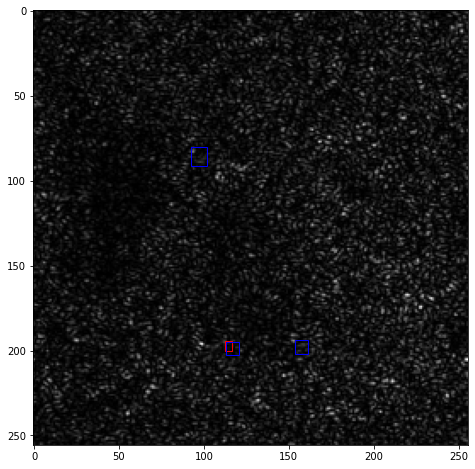

In [ ]:
all = False # for _, all in enumerate(show_all_boxes):
for _, source_event in enumerate(source_events): 
  imagepaths = sorted(os.listdir(source_event))
  images = [cv2.imread(f'{source_event}/{path}') for i, path in enumerate(imagepaths)]
  print(f"Processing {source_event} - {'all boxes' if all else 'single box'}")
  for i in range(256):
    if ('_76' not in imagepaths[i]):
      continue
    tensor_img = transforms(images[i])

    model_2.eval()
    with torch.no_grad(): 
      prediction_test = model_2([tensor_img.to(device)])
      print(prediction_test)
      print(imagepaths[i])
      if prediction_test[0]['boxes'].any():
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(images[i])

        if all:
          for k in range(len(prediction_test[0]['boxes'])):
            if prediction_test[0]['scores'][k] > 0.15:
              box = prediction_test[0]['boxes'][k].cpu().numpy() 
              r = get_rect(box[0], box[1], box[2], box[3],color='b' if k > 0 else 'r')
              ax.add_patch(r)
        else:
          box = prediction_test[0]['boxes'][0].cpu().numpy() 
          r = get_rect(box[0], box[1], box[2], box[3],color='b' if k > 0 else 'r')
          ax.add_patch(r)
        plt.show()

        # plt.savefig(f"detections{'_all' if all else ''}_{source_event}/detected_regions_{imagepaths[i]}")
        # plt.close(fig) 

In [ ]:
!zip -r detections_2011_12_30.zip detections_2011_12_30_event/

In [ ]:
!zip -r detections_2012_05_08.zip detections_2012_05_08_event/

In [ ]:
!zip -r detections_all_2011_12_30.zip detections_all_2011_12_30_event/

In [ ]:
!zip -r detections_all_2012_05_08.zip detections_all_2012_05_08_event/

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

# Visualize

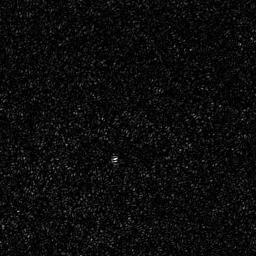

In [50]:
img, f = dataset_test[2]
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
im

/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_1996_07_09_09_01_00_79.jpg


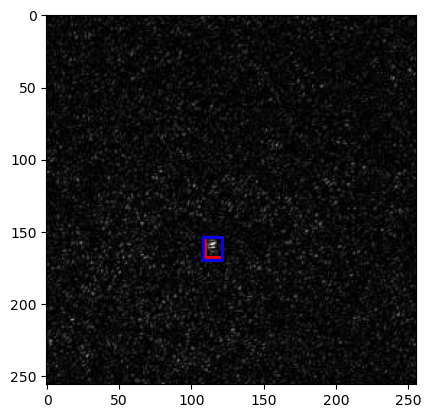

In [61]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
print(dataset_.imgs[f['image_id']])

fig, ax = plt.subplots()
ax.imshow(im)

box = f['boxes'][0].cpu().numpy()

with torch.no_grad():
    prediction = model([img.float().to(device)])
    
r = get_rect(box[0], box[1], box[2], box[3], color='r')

box = prediction[0]['boxes'][0].cpu().numpy()

r2 = get_rect(box[0], box[1], box[2], box[3], color='b')


ax.add_patch(r)
ax.add_patch(r2)
plt.show()

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

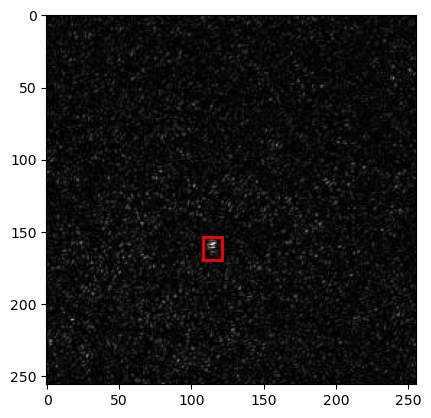

In [62]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

fig, ax = plt.subplots()
ax.imshow(im)

box = prediction[0]['boxes'][0].cpu().numpy()

r = get_rect(box[0], box[1], box[2], box[3], color='r')

ax.add_patch(r)
plt.show()

# Apply / Visualise C23

In [29]:
model = model_2

In [21]:
ims_train = dataset

In [32]:
# # pick one image from the test set

# for i in range(len(dataset)):
#   img, f = dataset[i]
#   # put the model in evaluation mode
#   model.eval()
#   with torch.no_grad(): 
#     prediction = model([img.float().to(device)])

#     im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
#     print(dataset_.imgs[f['image_id']])

#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.imshow(im)
#     box = f['boxes'][0].cpu().numpy()
#     r = get_rect(box[0], box[1], box[2], box[3])
#     ax.add_patch(r)
#     # plt.show()

#     # fig, ax = plt.subplots()
#     # ax.imshow(im)
#     if (len(prediction[0]['boxes'])>0):
#       box = prediction[0]['boxes'][0].cpu().numpy()
#       r = get_rect(box[0], box[1], box[2], box[3], color='b')
#       ax.add_patch(r)
#     plt.show()

In [33]:
dataset[0]

(tensor([[[0.0196, 0.1098, 0.1333,  ..., 0.0000, 0.0000, 0.0863],
          [0.0196, 0.0588, 0.0941,  ..., 0.0941, 0.0549, 0.0000],
          [0.0157, 0.0196, 0.0000,  ..., 0.0157, 0.0039, 0.1020],
          ...,
          [0.0000, 0.0745, 0.0000,  ..., 0.1686, 0.0000, 0.0000],
          [0.0588, 0.1059, 0.0000,  ..., 0.2627, 0.0510, 0.0902],
          [0.0000, 0.1176, 0.0392,  ..., 0.1765, 0.0000, 0.0902]],
 
         [[0.0196, 0.1098, 0.1333,  ..., 0.0000, 0.0000, 0.0863],
          [0.0196, 0.0588, 0.0941,  ..., 0.0941, 0.0549, 0.0000],
          [0.0157, 0.0196, 0.0000,  ..., 0.0157, 0.0039, 0.1020],
          ...,
          [0.0000, 0.0745, 0.0000,  ..., 0.1686, 0.0000, 0.0000],
          [0.0588, 0.1059, 0.0000,  ..., 0.2627, 0.0510, 0.0902],
          [0.0000, 0.1176, 0.0392,  ..., 0.1765, 0.0000, 0.0902]],
 
         [[0.0196, 0.1098, 0.1333,  ..., 0.0000, 0.0000, 0.0863],
          [0.0196, 0.0588, 0.0941,  ..., 0.0941, 0.0549, 0.0000],
          [0.0157, 0.0196, 0.0000,  ...,

In [37]:
im, f = dataset[0]
dataset.imgs[f['image_id']]

'/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2004_07_16_13_48_00_58.jpg'

In [48]:
len(dataset)

115

In [ ]:
evaluate(model_2, data_loader_test)

In [30]:
# pick one image from the test set

for i in range(0,len(dataset_test)):
  img, f = dataset_test[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad(): 
    prediction = model([img.float().to(device)])

    im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    print(dataset_test.imgs[f['image_id']])

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(im)
    box = f['boxes'][0].cpu().numpy()
    r = get_rect(box[0], box[1], box[2], box[3])
    ax.add_patch(r)
    # plt.show()

    # fig, ax = plt.subplots()
    # ax.imshow(im)
    if (len(prediction[0]['boxes'])>0):
      box = prediction[0]['boxes'][0].cpu().numpy()
      r = get_rect(box[0], box[1], box[2], box[3], color='b')
      ax.add_patch(r)
    # plt.show()
    plt.savefig(f"imgs_c24_test/detected_regions_{dataset_test.imgs[f['image_id']].split('/')[-1]}", transparent=True)
    plt.close(fig) 

/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2011_09_07_22_32_00_86.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2014_11_09_15_24_00_89.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2017_09_07_10_11_00_88.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2013_11_10_05_08_00_97.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2012_03_06_12_23_00_114.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2014_11_09_15_24_00_96.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2012_03_06_12_23_00_108.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2012_07_05_03_25_00_95.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2015_03_11_16_11_00_96.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2012_07_04_14_35_00_90.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2015_03_11_16_11_00_101.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2012_03_05_19_27_00_91.jpg
/home/vanessa-m/Dev/Datasets/C24_pos/poz/img_poz_2015_01_03_09_40_00_94.jpg
/home/van

In [49]:
# pick one image from the test set

for i in range(0,len(dataset_test)):
  img, f = dataset_test[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad(): 
    prediction = model([img.float().to(device)])

    im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    print(dataset_test.imgs[f['image_id']])

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(im)
    box = f['boxes'][0].cpu().numpy()
    r = get_rect(box[0], box[1], box[2], box[3])
    ax.add_patch(r)
    # plt.show()

    # fig, ax = plt.subplots()
    # ax.imshow(im)
    if (len(prediction[0]['boxes'])>0):
      box = prediction[0]['boxes'][0].cpu().numpy()
      r = get_rect(box[0], box[1], box[2], box[3], color='b')
      ax.add_patch(r)
    # plt.show()
    plt.savefig(f"imgs_c23_test/detected_regions_{dataset_test.imgs[f['image_id']].split('/')[-1]}", transparent=True)
    plt.close(fig) 

/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2003_10_23_08_45_00_35.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2003_10_23_08_45_00_38.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_1996_07_09_09_01_00_79.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2000_06_06_14_57_00_52.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_1996_07_09_09_01_00_86.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2003_10_29_20_35_00_147.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2003_10_29_20_35_00_142.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2000_06_06_14_57_00_55.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2000_06_06_14_57_00_65.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2003_10_23_08_45_00_37.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2000_06_06_14_57_00_51.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2003_10_29_20_35_00_144.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2000_06_06_14_57_00_48.jpg
/home/van

In [44]:
# pick one image from the test set

for i in range(60,len(dataset)):
  img, f = dataset[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad(): 
    prediction = model([img.float().to(device)])

    im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    print(dataset.imgs[f['image_id']])

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(im)
    box = f['boxes'][0].cpu().numpy()
    r = get_rect(box[0], box[1], box[2], box[3])
    ax.add_patch(r)
    # plt.show()

    # fig, ax = plt.subplots()
    # ax.imshow(im)
    if (len(prediction[0]['boxes'])>0):
      box = prediction[0]['boxes'][0].cpu().numpy()
      r = get_rect(box[0], box[1], box[2], box[3], color='b')
      ax.add_patch(r)
    # plt.show()
    plt.savefig(f"imgs_c23/detected_regions_{dataset.imgs[f['image_id']].split('/')[-1]}", transparent=True)
    plt.close(fig) 

/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2005_01_15_00_33_00_53.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2001_04_06_19_13_00_36.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2001_04_10_05_01_00_51.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2002_08_21_05_24_00_52.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2001_09_24_09_35_00_39.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2002_08_21_05_24_00_45.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2001_04_06_19_13_00_24.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2002_08_21_05_24_00_58.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2002_08_21_05_24_00_57.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2002_07_23_00_27_00_30.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2005_01_15_00_33_00_51.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2005_01_15_00_33_00_48.jpg
/home/vanessa-m/Dev/Datasets/C23_pos/poz/img_poz_2005_01_15_00_33_00_40.jpg
/home/vaness

# Apply C24

In [53]:
# use our dataset and defined transformations
dataset = SegDataset('/home/vanessa-m/Dev/Datasets/C24_pos', 'train', get_transform(train=True))
dataset_test = SegDataset('/home/vanessa-m/Dev/Datasets/C24_pos', 'test', get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

ValueError: not enough values to unpack (expected 3, got 0)